<a href="https://colab.research.google.com/github/pauloigorms/covid-twitter-pecd/blob/main/Programacao_Ciencia_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROGRAMAÇÃO PARA CIÊNCIA DE DADOS**

**Equipe**: Cássio de Paula / Paulo Moraes [(website)](https://paulomoraes.me).

**Objetivo**: analisar as mensagens
trocadas por usuários do Twitter sobre a COVID-19, com o intuito de realizar uma análise
exploratória e visualização de dados, passando também pelas etapas de limpeza e organização.
Mais especificamente, as equipes devem explorar a análise nas perguntas (questões) dos usuários,
pois arguimos que seja um tipo de mensagem apropriado para se compreender as principais dúvidas
das pessoas sobre a atual pandemia.


# **INFORMAÇÕES GERAIS**

### **ARTEFATOS**


*   Relatório Técnico - *Um notebook com o texto e o código-fonte apresentado na ferramenta Google COLAB*; 
*   Repositório no GitHub.


### **ATIVIDADES**


*   Importar base de dados;
*   Tratar base de dados;
*   Identificar as perguntas (questões) descritas nas mensagens;
*   Salvar coleção com a identificação das perguntas em um novo dataset chamado "DuvidasDB".


### **DO RESULTADO**


1.   Devem apresentar um resumo (sumário) com as estatísticas dos dados originais, elas podem ser apresentadas através de tabelas e/ou gráficos;
2.   Com a coleção resultando da identificação das perguntas a equipe deve apresentar as estatísticas sobre estes dados.


### **TEMAS DISCUTIDOS**

As equipes devem fazer uma análise sobre os temas que são debatidos nas perguntas dos postadas pelos usuários. Faça uma análise se as perguntas são relativas aos seguintes temas:

*   Doença. Quando a pergunta é relativa à doença Deve-se observar que a doença é identificada por vários nomes. Exemplo: coronavírus, corona, COVID-19, etc;
*   Medicamento. Quando a pergunta é sobre o uso de determinado medicamento no tratamento da doença;
*   Organizações. Quando a pergunta é relativa a uma determinada entidade ou organização. Emissora de TV, Ministério da Saúde ou empresas são exemplos de organizações;
*   Pessoas. Quando a pergunta é sobre determinada pessoa. Por exemplo, a pergunta pode ser sobre a atuação que determinado político ou pessoa famosa teve durante esse período de pandemia.

# **VISÃO DOS DADOS**

> **Visão Temporal** - Deve-se fazer uma análise temporal das perguntas que formam o dataset *DuvidasDB*. Pode-se considerar o intervalo temporal de dias, semanas ou meses. A escolha do intervalo de tempo ficará a cargo das equipes. Exemplos de análise temporal: a) houve um aumento no número de perguntas
ao longo do tempo? b) houve uma mudança no perfil das perguntas ao longo do tempo?

> **Visão Geográfica** - Deve-se fazer uma análise geográfica (espacial) das perguntas que formam o dataset *DuvidasDB*. Existem algumas colunas no dataset que trazem a informação das localizações como, por exemplo, o país, estado e cidade. Em alguns tuítes é possível ainda identificar as coordenadas geográficas
de latitude e longitude. Exemplo de análise geográfica: a) os usuários de regiões diferentes fazem
perguntas com diferentes focos? Por exemplo, será que os usuários de uma região perguntam mais
sobre a doença ou sobre o tratamento? Essa análise ainda pode ser realizada em diversos níveis de
área (cidade, estado ou região). Além de apresentar a distribuição das dúvidas dos usuários por
região, a equipe deverá fazer uma análise dessa distribuição. Por exemplo, apresentar as razões
(ou hipóteses) da ocorrência dessa distribuição.


# **INICIANDO O PROJETO**

IMPORTANDO LIBS

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import nltk as nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, ImageColorGenerator

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


LEITURA DO ARQUIVO DE DADOS BASE

In [83]:
drive.mount('/content/drive')
load_data = pd.read_csv('drive/My Drive/twitter/dados-curso-completo.csv', sep= ',',skiprows=0, encoding='utf-8')
#duvidasdb = pd.read_csv('drive/My Drive/twitter/duvidasdb.csv', sep= ',',skiprows=0, encoding='utf-8')
raw_data = load_data.drop_duplicates(['texto'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Funções

Função: **Cálcular Percente**

In [ ]:
def calc_percente(value, total): 
    if not value and not total: 
       return print("value = 0% \n total = 0%") 
    elif value < 0 or total < 0: 
       return print("não aceita valor negativo!") 
    else: 
       return print('{0:.2f}%'.format((value / total * 100)))

Função: **Formatar String**

In [ ]:
def spliting(text):
  return text.split()

#Estatísticas bases


**Exemplo da base de dados**

---



In [66]:
raw_data.head(5)
# nodp_data.info()

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
0,2020-03-23 18:51:14,Gaboardi,fraslee,@BolsonaroSP Cade o fundão deputado??? Congres...,0,138,pt,NaN,NaN,NaN,NaN,NaN,[]
1,2020-03-18 03:18:14,Seu Zé da Farmácia,seuzedafarmacia,"Em ação preventiva, o Governo do Estado suspen...",0,56,pt,NaN,NaN,NaN,NaN,NaN,[]
2,2020-03-29 12:09:27,Marília Oliveira 🇧🇷,Marioliveira_gb,Incrível como os defensores do fim do distanci...,0,5,pt,NaN,NaN,NaN,NaN,NaN,[]
3,2020-04-01 21:11:07,🚩,santosodeto,Fumaça de cigarro pode propagar coronavírus? h...,0,1885,pt,NaN,NaN,NaN,NaN,NaN,[]
4,2020-03-19 17:49:40,Nova Impressão,novaimpressao_,🚨Todos juntos contra COVID-19💪\n\nSolicite seu...,0,124,pt,Brasília,Brazil,BR,-47.8778,-15.77691,[]


**Tamanha da base (com e sem dados duplicados)**

---

In [67]:
# Total com duplicados: 1.658.825
# Total sem duplicados = 1.653.599
raw_data.texto.count()

1653599

**Twitters por região**

---

In [68]:
# Total de twitters com localização = 74.383
raw_data['lugar'].count()

74383

In [69]:
# Percentual em relação à base = 4.50%
calc_percente(value=raw_data['lugar'].count(), total=raw_data.texto.count())

4.50%


In [70]:
# Total por país
raw_data[raw_data.pais == 'Brazil'].groupby('pais').count()

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,sigla,latitude,longitude,hashtags
pais,,,,,,,,,,,,
Brazil,67034,67033,67034,67034,67034,67034,67034,67034,67034,7675,7675,67034


In [71]:
# Total por localização
raw_data[raw_data.pais == 'Brazil'].groupby(['pais', 'lugar']).count()

data  ...  hashtags
pais   lugar                                                 ...          
Brazil 12° Batalhão de Infantaria do Exército (12 BI)     1  ...         1
       3ª Delegacia de Polícia (DP)                       1  ...         1
       89 A Rádio Rock                                    1  ...         1
       @oBarreiro - Capital Do MUNDO                     13  ...        13
       AABB                                               1  ...         1
...                                                     ...  ...       ...
       Águas de São Pedro                                 2  ...         2
       Álvares Machado                                    1  ...         1
       Álvaro de Carvalho                                 1  ...         1
       Érico Cardoso                                      1  ...         1
       Óbidos                                             2  ...         2

[2656 rows x 11 columns]

**Twitters por período**

---

In [72]:
df_data = pd.DataFrame(raw_data)
df_data['data'] = pd.to_datetime(df_data['data'])
df_data.index = df_data['data']
df_data.drop('data', inplace=True, axis=1)
df_res = df_data.resample('M').count()
df_res.reset_index(inplace=True)
df_res

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
0,2020-01-31,54388,54391,54391,54391,54391,54391,2177,2177,2177,80,80,54391
1,2020-02-29,109485,109489,109489,109489,109489,109489,4305,4305,4305,225,225,109489
2,2020-03-31,480112,480128,480128,480128,480128,480128,23487,23486,23484,2561,2561,480128
3,2020-04-30,469321,469334,469334,469334,469334,469334,21318,21317,21315,2516,2516,469334
4,2020-05-31,283219,283229,283229,283229,283229,283229,12780,12777,12777,1993,1993,283229
5,2020-06-30,257022,257027,257027,257027,257027,257027,10316,10316,10315,1345,1345,257027
6,2020-07-31,1,1,1,1,1,1,0,0,0,0,0,1


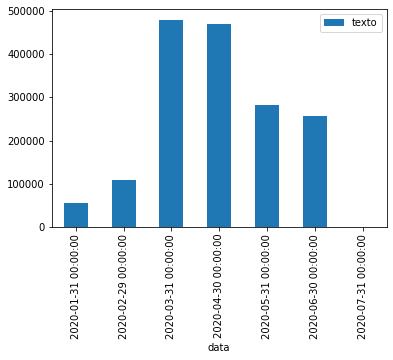

In [57]:
df_res.plot(kind='bar',x='data',y='texto')

**Mineração de Perguntas**

---






*Tamanho da coluna que precisa ser minerada*

In [76]:
valor = len(raw_data['texto'])
valor

1653599

*Amostra de checagem para suspeita de linhas com erros*

In [77]:
sentencas = sent_tokenize(raw_data['texto'][7159]) # this gives us a list of sentences
sentencas

['@TeichNelson @minsaude @Medicina_CFM @Astro_Pontes Ajudar a enxergar coisas no raio-x, que indicaram algo como o vi… https://t.co/zPbNfdIHll']

*Mineração para Recuperação de Perguntas na Base*

In [78]:
twitter = []
perguntas = []
erro = []
for i in range(0,valor):
  try:
    twitter.append(sent_tokenize(raw_data['texto'][i]))   
    for sentencas in twitter: 
      for row in sentencas:
        palavras = word_tokenize(row.lower())
        for palavra in palavras:
          if palavra == '?':
            perguntas.append([row,i]) 
            break
    twitter.clear()
  except:
    erro.append(i)     

 

Perguntas no twitter

In [ ]:
twitter = []
perguntas = []
erro = []
for i in range(0,valor):
  try:
    twitter.append(sent_tokenize(raw_data['texto'][i]))   
    for sentencas in twitter: 
      for row in sentencas:
        palavras = word_tokenize(row.lower())
        for palavra in palavras:
          if palavra == '?':
            perguntas.append([row,i]) 
            break
    twitter.clear()
  except:
    erro.append(i)     

 

*Resumo após a Mineração*

In [ ]:
len(erro)
#Quantidade de registros que quebrariam a mineração

5201

In [ ]:
len(perguntas)
#Quantidade de perguntas extraidas

205381

In [84]:
DuvidasDB = perguntas

**DataSet gerado para a análise**

In [121]:
df_DuvidasDB = pd.DataFrame(DuvidasDB, columns=['Perguntas','Indice'])
# df_DuvidasDB.to_csv(r'drive/My Drive/twitter/duvidasdb.csv', index = False)
# df_DuvidasDB.head(1)
question = df_DuvidasDB.Perguntas[1]
questions = " ".join(twitter for twitter in df_DuvidasDB.Perguntas)

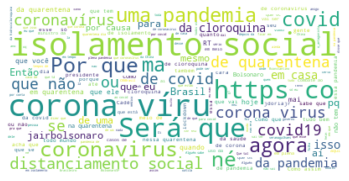

In [122]:
wordcloud = WordCloud(background_color="white").generate(questions)
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

*Rascunho geral*

In [ ]:
from nltk.corpus import stopwords
from string import punctuation
stopwords = set(stopwords.words('portuguese') + list(punctuation))
stopwords
#list(punctuation)

palavras_sem_stopwords = [palavra for palavra in sentencas if palavra not in stopwords]
palavras_sem_stopwords